# Disease Predition based on Symptoms using Neural Network

In [1]:
from pathlib import Path
import pandas as pd
from pandas import DataFrame
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from google_drive_downloader import GoogleDriveDownloader as gdd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import os


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = '/content/gdrive/My Drive/Data/Disease_Dataset/dataset.csv'


Mounted at /content/gdrive


- **Input dimension:**
  - Size of features: 132

- **Output dimension: 41**

In [4]:
# Hyperparameters
 
batch_size = 20
num_iters = 30000
hidden_layer1 = 100 # num of hidden nodes
hidden_layer2 = 64
learning_rate = 0.01
 
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# View some example records
pd.read_csv(DATA_PATH).sample(5)

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
1035,Hepatitis C,fatigue,yellowish_skin,nausea,yellowing_of_eyes,family_history,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,Jaundice,itching,vomiting,weight_loss,high_fever,yellowish_skin,dark_urine,abdominal_pain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3047,Paralysis (brain hemorrhage),vomiting,headache,weakness_of_one_body_side,altered_sensorium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,Hypothyroidism,weight_gain,cold_hands_and_feets,mood_swings,lethargy,dizziness,puffy_face_and_eyes,enlarged_thyroid,brittle_nails,swollen_extremeties,depression,irritability,abnormal_menstruation,NaN,NaN,NaN,NaN,NaN
3973,Acne,skin_rash,pus_filled_pimples,blackheads,scurring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Loading Dataset**

In [6]:
class Sequences(Dataset):
    def __init__(self, data):

        df = data.Symptom_1.map(str)+ ' ' + data.Symptom_2.map(str) + ' ' + data.Symptom_3.map(str) +' ' + data.Symptom_4.map(str)+ ' ' + data.Symptom_5.map(str) + ' ' + data.Symptom_6.map(str)+ ' ' + data.Symptom_7.map(str)+ ' ' + data.Symptom_8.map(str)+ ' ' + data.Symptom_9.map(str)+ ' ' + data.Symptom_10.map(str)+ ' ' + data.Symptom_11.map(str)+ ' ' + data.Symptom_12.map(str)+ ' ' + data.Symptom_13.map(str)+ ' ' + data.Symptom_14.map(str)+ ' ' + data.Symptom_15.map(str)+ ' ' + data.Symptom_16.map(str)+ ' ' + data.Symptom_17.map(str)
        
        self.vectorizer = CountVectorizer(binary=True)
        self.sequences = self.vectorizer.fit_transform(df)

        self.label = data.Disease.tolist()
        le = preprocessing.LabelEncoder()
        le.fit(self.label)
        self.labels = le.fit_transform(self.label)
        self.label_mapping = dict(zip(le.transform(le.classes_),le.classes_))

        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return torch.tensor(self.sequences[i, :].toarray()), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [7]:
# Read Dataset from csv file
df = pd.read_csv(DATA_PATH, na_filter= False)
print("Total Data:",len(df))

# Train Test Spliting
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, shuffle=True)

# Preproccessing of Dataset
train_data = Sequences(train)
test_data = Sequences(test)
#train_loader = DataLoader(train_data, batch_size=batch_size)
#test_loader = DataLoader(test_data, batch_size=batch_size)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

print("Train Data: ",len(train_data))
print("Test Data: ",len(test_data))


Total Data: 4920
Train Data:  4428
Test Data:  492


In [8]:
# Disease Label Dictionary
print("Disease Dictionary: ")
print(train_data.label_mapping)
print(train_data.labels)


Disease Dictionary: 
{0: '(vertigo) Paroymsal  Positional Vertigo', 1: 'AIDS', 2: 'Acne', 3: 'Alcoholic hepatitis', 4: 'Allergy', 5: 'Arthritis', 6: 'Bronchial Asthma', 7: 'Cervical spondylosis', 8: 'Chicken pox', 9: 'Chronic cholestasis', 10: 'Common Cold', 11: 'Dengue', 12: 'Diabetes ', 13: 'Dimorphic hemmorhoids(piles)', 14: 'Drug Reaction', 15: 'Fungal infection', 16: 'GERD', 17: 'Gastroenteritis', 18: 'Heart attack', 19: 'Hepatitis B', 20: 'Hepatitis C', 21: 'Hepatitis D', 22: 'Hepatitis E', 23: 'Hypertension ', 24: 'Hyperthyroidism', 25: 'Hypoglycemia', 26: 'Hypothyroidism', 27: 'Impetigo', 28: 'Jaundice', 29: 'Malaria', 30: 'Migraine', 31: 'Osteoarthristis', 32: 'Paralysis (brain hemorrhage)', 33: 'Peptic ulcer diseae', 34: 'Pneumonia', 35: 'Psoriasis', 36: 'Tuberculosis', 37: 'Typhoid', 38: 'Urinary tract infection', 39: 'Varicose veins', 40: 'hepatitis A'}
[ 4 11 36 ... 12 15 33]


**Dataset Analysis**

In [ ]:
print("Number of Features in a Input Vector: ",len(train_data.token2idx))
unique_words = set(train_data.labels) 
print("Number of Classes(Disease): ",len(unique_words))
print("Number of Vocabulary: ",len(train_data.token2idx))
print("Number of Train Samples: ",len(train_data))
print("Number of Test Samples: ",len(test_data),"\n")

# Printing name of the each classes and their number of Train Samples
(unique, counts) = np.unique(train_data.label, return_counts=True)
frequencies = np.array((unique, counts)).T
cls_train_sam = DataFrame(frequencies,columns=['Classes','Number of Train Samples'])
print("Each Class with their number of Train Samples taken for train this model:")
print(cls_train_sam)

# Vocabulary List
print("\nFeatures Vocabulary list and their index: \n",sorted(train_data.idx2token.items()))


Number of Features in a Input Vector:  132
Number of Classes(Disease):  41
Number of Vocabulary:  132
Number of Train Samples:  4428
Number of Test Samples:  492 

Each Class with their number of Train Samples taken for train this model:
                                    Classes Number of Train Samples
0   (vertigo) Paroymsal  Positional Vertigo                     107
1                                      AIDS                     109
2                                      Acne                     108
3                       Alcoholic hepatitis                     107
4                                   Allergy                     107
5                                 Arthritis                     106
6                          Bronchial Asthma                     112
7                      Cervical spondylosis                     109
8                               Chicken pox                     102
9                       Chronic cholestasis                     107
10            

**Sample Input Vector**

In [ ]:
# Sample Input Vector
def sampleData(idx):
  print("\nSample Input Vector: ")
  print(train_data[idx])
  sorted_voc = sorted(train_data.idx2token.items())
  print("\nIn the above input, these following index values are One: ")
  print("Index\t\tIndex Meaning\n*****\t\t********************")
  for i in range(len(train_data[idx][0][0])):
    if(train_data[idx][0][0][i] >= 1):
      print(i,"\t\t",sorted_voc[i][1])
  print("\nLabel: ", train_data.label_mapping[train_data[idx][1]])

sampleData(0)


Sample Input Vector: 
(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]), 20)

In the above input, these following index values are One: 
Index		Index Meaning
*****		********************
39 		 family_history
41 		 fatigue
60 		 loss_of_appetite
71 		 nausea
130 		 yellowing_of_eyes
131 		 yellowish_skin

Label:  Hepatitis C


###Step #1 : Neural Network Model Design


In [ ]:
class BagOfWordsClassifier(nn.Module):
    def __init__(self, vocab_size, hidden1, hidden2):
        super().__init__()
        ### 1st hidden layer: vocab_size --> 128
        self.linear_1 = nn.Linear(vocab_size, hidden1)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()
        
        ### 2nd hidden layer: 128 --> 64
        self.linear_2 = nn.Linear(hidden1, hidden2)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()
        
        ### Output layer: 64 --> 1
        self.linear_out = nn.Linear(hidden2, len(train_data.label_mapping))
        
    def forward(self, inputs):
        ### 1st hidden layer
        out = self.linear_1(inputs)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
        
        # Linear layer (output)
        logits  = self.linear_out(out)
        
        return logits

In [ ]:
model = BagOfWordsClassifier(len(train_data.token2idx), hidden_layer1, hidden_layer2)
model.to(device)

BagOfWordsClassifier(
  (linear_1): Linear(in_features=132, out_features=100, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=64, bias=True)
  (relu_2): ReLU()
  (linear_out): Linear(in_features=64, out_features=41, bias=True)
)

###Step #2 : Constructing loss and optimizer (select from PyTorch API)


In [ ]:
# INSTANTIATE OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
path = "../content/gdrive/My Drive/Data/saved_model/Disease_prediction/"

# Create Directory
saveModel = path + 'i' + str(num_iters) +'_b' + str(batch_size) +'_L' + str(learning_rate)
check_dir = os.listdir(path)
if ('i' + str(num_iters) +'_b' + str(batch_size) +'_L' + str(learning_rate) not in check_dir):
  os.mkdir(saveModel)

# Writing number of input layer and their specification of this model
layer_specification_path = path + 'i'+ str(num_iters) + '_b' + str(batch_size) +'_L' + str(learning_rate) +'/layer_specification.txt'
model_text = model.to(device)
f = open(layer_specification_path, "w")
f.write(str(model_text))
f.close()

# Save Model
def saveModel(batch,iteration,learningRate):
  save_model = True
  if save_model is True:
      # Saves only parameters
      # wights & biases
      torch.save(model.state_dict(), path + 'i' + str(num_iters) + '_b' + str(batch_size) +'_L' + str(learning_rate) + '/logistic_i' + str(iteration) +'_b' + str(batch_size) +'_L' + str(learning_rate) +'.pkl') 

##Step #3: Model Training

In [ ]:
iteration_loss = []
iter = 1

In [ ]:
'''
TRAIN THE MODEL
'''
loss_path = path + 'i'+ str(num_iters) + '_b' + str(batch_size) +'_L' + str(learning_rate) +'/accuracy_loss.txt'
f = open(loss_path, "a")
f.write("Iteration\tLoss\tAccuracy\n")
f.close()
 
for epoch in range(num_epochs):
    for i, (input, labels) in enumerate(train_loader):
        input = input.view(-1, 132).float().to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(input)
        #outputs = torch.argmax(outputs, dim=1)
        #print(outputs)
        #print(labels)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
        optimizer.step()
        
        print("\rIteration:{}".format(iter), end="")
        iter += 1
        if iter % 1000 == 0:
            saveModel(batch_size, iter,learning_rate)
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for input, labels in test_loader: 
                # Forward pass only to get logits/output
                input = input.view(-1, 132).float().to(device)
                labels = labels.to(device)
                outputs = model(input)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iteration_loss.append(loss.item())
            print('\nIteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            f = open(loss_path, "a")
            f.write(str(iter) + "\t" + str(loss.item()) + "\t"+ str(accuracy) +"\n")
            f.close()

Iteration:499
Iteration: 500. Loss: 3.6603217124938965. Accuracy: 14.024390243902438
Iteration:999
Iteration: 1000. Loss: 3.5937187671661377. Accuracy: 30.08130081300813
Iteration:1499
Iteration: 1500. Loss: 3.3157451152801514. Accuracy: 38.61788617886179
Iteration:1999
Iteration: 2000. Loss: 2.9130001068115234. Accuracy: 37.80487804878049
Iteration:2499
Iteration: 2500. Loss: 2.0484917163848877. Accuracy: 63.00813008130081
Iteration:2999
Iteration: 3000. Loss: 1.6701288223266602. Accuracy: 88.82113821138212
Iteration:3499
Iteration: 3500. Loss: 0.9356218576431274. Accuracy: 100.0
Iteration:3999
Iteration: 4000. Loss: 0.4839943051338196. Accuracy: 99.79674796747967
Iteration:4499
Iteration: 4500. Loss: 0.26158270239830017. Accuracy: 100.0
Iteration:4999
Iteration: 5000. Loss: 0.15219774842262268. Accuracy: 100.0
Iteration:5499
Iteration: 5500. Loss: 0.11389371007680893. Accuracy: 100.0
Iteration:5999
Iteration: 6000. Loss: 0.056225068867206573. Accuracy: 100.0
Iteration:6499
Iteration:

### Load Model and iteration Loss

In [ ]:
root_path = '/content/gdrive/My Drive/Data/saved_model/Disease_prediction/i20000_b20_L0.01/'

# read train.txt file line by line
with open(root_path + 'accuracy_loss.txt', "r") as loss:
    FileasList = loss.readlines()

acc_loss = []
iteration_loss = []
for i in range(len(FileasList)):
  if (i == 0):
    continue
  acc_loss.append(FileasList[i].split())
  iteration_loss.append(float(acc_loss[i-1][1]))


load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'logistic_i15000_b20_L0.01.pkl'))

**Loss Graph:**

[3.6603217124938965, 3.5937187671661377, 3.3157451152801514, 2.9130001068115234, 2.0484917163848877, 1.6701288223266602, 0.9356218576431274, 0.4839943051338196, 0.26158270239830017, 0.15219774842262268, 0.11389371007680893, 0.056225068867206573, 0.06252476572990417, 0.061545826494693756, 0.023853857070207596, 0.015490430407226086, 0.032239723950624466, 0.025835376232862473, 0.02619210258126259, 0.02075781300663948, 0.018518943339586258, 0.011131225153803825, 0.020588640123605728, 0.0081477714702487, 0.006028329022228718, 0.011922657489776611, 0.01078159548342228, 0.0065200962126255035, 0.009186040610074997, 0.004342779517173767, 0.010518299415707588, 0.009607570245862007, 0.010466600768268108, 0.008220125921070576, 0.00713436771184206, 0.005366389639675617, 0.018349573016166687, 0.006740304175764322, 0.006298243999481201]


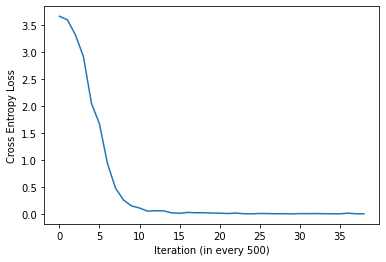

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

**Disease Predict**

In [ ]:
def predict_sentiment(text):
  test_vector = torch.LongTensor(train_data.vectorizer.transform([text]).toarray())
  output = model(test_vector.to(device).float())
  prediction = torch.argmax(output, dim=1)
  output = train_data.label_mapping[prediction.item()]
  return output

In [ ]:
test_text = "vomiting  weight_loss high_fever yellowish_skin dark_urine abdominal_pain"
print(predict_sentiment(test_text))
test_text = "itching skin_rash fatigue headache red_spots_over_body high_fever loss_of_appetite"
print(predict_sentiment(test_text))
test_text = "sweating vomiting  breathlessness"
print(predict_sentiment(test_text))

Jaundice
Chicken pox
Heart attack
